# Gold and USD inflation
Using monthly data we will explore the relationship between gold prices and
inflation.

### Inspirations
- [The FRED® Blog: Is gold a good hedge against inflation?]
(https://fredblog.stlouisfed.org/2019/03/is-gold-a-good-hedge-against-inflation/)

### Definitions
- Gold: The ICE Benchmark Administration Limited (IBA), Gold Fixing Price in
the London Bullion Market, based in U.S. Dollars, retrieved from FRED,
Federal Reserve Bank of St. Louis
- CPI inflation: Consumer Price Index, seasonally adjusted monthly since 1947,
, retrieved from FRED, Federal Reserve Bank of St. Louis
- PCE inflation: Personal Consumption Expenditure, seasonally adjusted monthly
since 1959, retrieved from FRED, Federal Reserve Bank of St. Louis
- SYN inflation: Synthetic Inflation, normalized and averaged over CPI,
CPI Core, PCE and PCE Core inflation measures, retrieved from FRED, Federal
Reserve Bank of St. Louis

### Dependencies:
- Python: matplotlib, pandas, fecon236, statsmodels, sympy, pandas_datareader
- Written using Python 3.8.5


In [1]:
# SETUP :: Settings, system details, import modules as necessary
import fecon236 as fe   # Useful econometrics python module for access and using U.S. Federal Reserve and related data
fe.system.specs()
pwd = fe.system.getpwd()   # present working directory as a variable
print(" :: $pwd", pwd)
#  If a module is modified, automatically reload it:
%load_ext autoreload
%autoreload 2
#       Use 0 to disable this feature.

#  Notebook DISPLAY options:
#      Represent pandas DataFrames as text; not HTML representation:
import pandas as pd
pd.set_option( 'display.notebook_repr_html', False )

from matplotlib import pyplot as plt
#  Generate PLOTS inside notebook, "inline" generates static png:
# %matplotlib inline
%matplotlib notebook
#          "notebook" argument allows interactive zoom and resize.
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
# Set up sympy for printing formulae later
import sympy as sp
sp.init_printing(use_latex='mathjax')
x, y, b_0, b_1, b_2, b_3 = sp.symbols('x y b_0 b_1 b_2 b_3')


 !:  Code for this project straddles python27 and python3.
 ::  Python 3.8.5
 ::  IPython 7.18.1
 ::  jupyter_core 4.6.3
 ::  jupyter_client 6.1.7
 ::  notebook 6.1.4
 ::  matplotlib 3.3.1
 ::  numpy 1.19.2
 ::  scipy 1.5.2
 ::  statsmodels 0.12.0
 ::  sympy 1.6.2
 ::  pandas 1.1.2
 ::  pandas_datareader 0.9.0
 ::  fecon236 10.8.0
 ::  Repository: git_repo_None tag_None branch_None
 ::  Timestamp: 2020-09-16T01:08:47Z
 :: $pwd E:\GitRepos\Yilgarn\nb


## Retrieve Data, Determine Appropiate Start and End Dates for Analysis

In [2]:
# Get gold and inflation rates, both as monthly frequency
# Notes: fecon236 uses median to resample (instead of say mean) and also
# replaces FRED empty data (marked with a ".") with data from previously
# occuring period; These adjustments will drive some small differences to
# the analysis on th FRED blog
# Daily London AM gold fix, nominal USD, converted to monthly
goldN = fe.monthly( fe.get( 'GOLDAMGBD228NLBM' ) )
# Daily London PM gold fix, nominal USD, converted to monthly
# goldN = fe.get( fe.m4xau )
goldNpchg = fe.nona( fe.pcent( goldN ) )    # Percentage change, removed NaN's

In [3]:
# Inflation in use
infcode = fe.m4cpi      # FRED code 'CPIAUCSL'
# infcode = fe.m4pce    # FRED code 'PCEPI'
# Synthetic average of 'CPIAUCSL', 'CPILFESL', 'PCEPI', 'CPILFESL'
# infcode = fe.m4infl
infIdx = fe.get ( fe.m4cpi )        # Index, not percentage change
infpchg = fe.nona( fe.pcent(infIdx ) )  # Percentage change, removed NaN's

In [4]:
# Gold with USD inflation removed i.e. in real USD
infBasedate = '2020-08-01'              # The base date for our index
infBase = infIdx['Y'][infBasedate]      # Base date index value
infIdxRebased = fe.div(infIdx, infBase) # Index rebased

In [5]:
# Find the first and last overlapping dates for the two data series
start = max(fe.head( goldN, 1).index[0], fe.head( infIdx, 1).index[0])
end = min(fe.tail( goldN, 1).index[0], fe.tail( infIdx, 1).index[0])

In [6]:
# Calculate the real gold price
goldR = fe.div(goldN.loc[start:end], infIdxRebased.loc[start:end])
goldRpchg = fe.nona( fe.pcent( goldR ) )    # Percentage change, removed NaN's

In [7]:
# Manual start and ending date over-rides
start = '1970-01-01'    # Date to align with Fed blog
end = '2020-08-01'    # Date to align with Fed blog

## Define a Custom Function to Dispaly Summary Statistics and Plot Data

In [8]:
def statsandplot(x, y):
    fe.stat2( y, x)                 # Display summary statistics
    model = fe.regress( y, x )      # Calculate ols liner model
    coef = model.params.tolist()    # Model coefficients
    poly1d_fn = np.poly1d(coef)     # Create function from coefficients
    # Display data and model
    result = plt.plot( x, y, 'yo', x, poly1d_fn(x), '--k')
    return

## Look at the Correlation of Month on Month Inflation and Change in Nominal Gold Prices

 ::  FIRST variable:
count    608.000000
mean       0.785983
std        5.076597
min      -17.549793
25%       -1.836479
50%        0.071386
75%        2.709308
max       41.120278
Name: Y, dtype: float64

 ::  SECOND variable:
count    608.000000
mean       0.318447
std        0.330304
min       -1.770548
25%        0.150792
50%        0.267113
75%        0.469649
max        1.809955
Name: Y, dtype: float64

 ::  CORRELATION
0.16271693542025506
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     16.48
Date:                Tue, 15 Sep 2020   Prob (F-statistic):           5.56e-05
Time:                        21:08:52   Log-Likelihood:                -1841.8
No. Observations:                 608   AIC:                             368

<IPython.core.display.Javascript object>


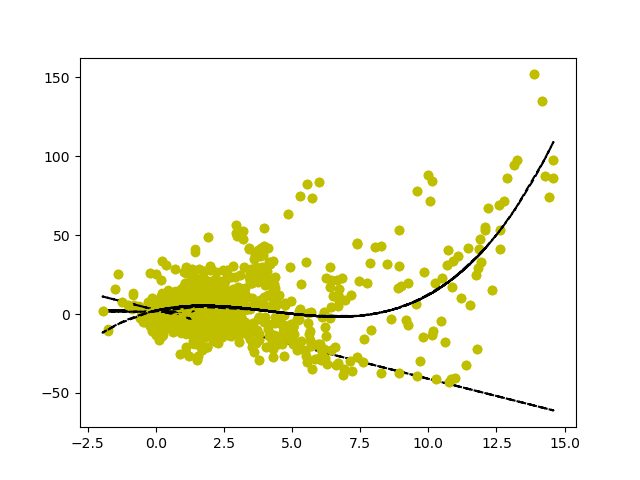

In [9]:
x = infpchg['Y'][start:end]
y = goldNpchg['Y'][start:end]
statsandplot(x, y)

2020-09-15: The regression analysis shows a strong relationship
(t-stat 4.06), however we need to remove the inflation contained in the
nominal gold price

## Look at the Correlation of Month on Month Inflation and Change in Real Gold Prices

In [10]:
x = infpchg['Y'][start:end]
y = goldRpchg['Y'][start:end]
statsandplot(x, y)

 ::  FIRST variable:
count    608.000000
mean       0.464436
std        5.005076
min      -18.682068
25%       -2.099698
50%       -0.153297
75%        2.425197
max       39.130120
Name: Y, dtype: float64

 ::  SECOND variable:
count    608.000000
mean       0.318447
std        0.330304
min       -1.770548
25%        0.150792
50%        0.267113
75%        0.469649
max        1.809955
Name: Y, dtype: float64

 ::  CORRELATION
0.09822065376682196
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     5.903
Date:                Tue, 15 Sep 2020   Prob (F-statistic):             0.0154
Time:                        21:08:52   Log-Likelihood:                -1838.4
No. Observations:                 608   AIC:                             368

2020-09-15: The regression analysis shows a relationship
(t-stat 2.43), with a 1% increase in inflation having a 0.0095% decrease in
the real price of gold. This is a very small movement.

## Look at the Correlation of Year on Year Inflation and Change in Nominal Gold Prices

In [11]:
# Change percentage calcualtion to every 12 months
freq = 12
goldRpchg = fe.nona( fe.pcent( goldR, freq ) )
infpchg = fe.nona( fe.pcent(infIdx, freq ) )

In [12]:
# Show same analysis as above
x = infpchg['Y'][start:end]
y = goldRpchg['Y'][start:end]
statsandplot(x, y)

 ::  FIRST variable:
count    608.000000
mean       5.925751
std       24.263099
min      -42.941169
25%       -9.228558
50%        2.156939
75%       17.315337
max      151.801206
Name: Y, dtype: float64

 ::  SECOND variable:
count    608.000000
mean       3.964192
std        2.952517
min       -1.958761
25%        2.071569
50%        3.139299
75%        4.812267
max       14.592275
Name: Y, dtype: float64

 ::  CORRELATION
0.3157299019262588
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     67.10
Date:                Tue, 15 Sep 2020   Prob (F-statistic):           1.54e-15
Time:                        21:08:52   Log-Likelihood:                -2769.2
No. Observations:                 608   AIC:                             5542

2020-09-15: The regression analysis shows a relationship
(t-stat 8.191), with a 1% increase in inflation having a 4.36% decrease in
the real price of gold; so actually showing a decrease in the real price
when the inflation increases; **an unexpected result**

### Alternative Models for Yearly Inflation and Real prices
First, lets explore a polynomial model

In [13]:
# Define our model
# Two degree polynomial of the form
f = b_0 + b_1 * x + b_2 * x**2
degree = 2
degree = 3
polyFeatures = PolynomialFeatures(degree)
# Reshape data from 1 by n to n by 1
xarray = np.array(x)
xarray = xarray[:, np.newaxis]
# Calculate polynomials for x
xp = polyFeatures.fit_transform(xarray)
# Reshape y from 1 by n to n by 1
yarray = np.array(y)
yarray = yarray[:, np.newaxis]
# Calculate the model and predictions
model = sm.OLS( yarray, xp ).fit()
ypred = model.predict(xp)
# Display the result
result = plt.plot( x, y, 'yo', x, ypred, '--k')
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.272
Model:                            OLS   Adj. R-squared:                  0.268
Method:                 Least Squares   F-statistic:                     75.08
Date:                Tue, 15 Sep 2020   Prob (F-statistic):           2.78e-41
Time:                        21:08:53   Log-Likelihood:                -2704.8
No. Observations:                 608   AIC:                             5418.
Df Residuals:                     604   BIC:                             5435.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2548      2.660      0.848      0.3

2020-09-15: For `degree=2` We show a stronger relationship, however it is
not clear why a quadractic equation is an appropiate relationship between
inflation and gold prices
Adj. R-squared:                  0.212
==============================================================================
                coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.3537      2.304      5.362      0.000       7.829      16.878
x1            -5.8708      0.949     -6.189      0.000      -7.734      -4.008
x2             0.6899      0.073      9.394      0.000       0.546       0.834
==============================================================================
For `degree=3`, relationship is weaker


 STOP
 STOP
 STOP
 STOP
 STOP
 STOP



#############################################
##
## Scratch pad code
##
#############################################

goldUSDd = fe.get( 'GOLDAMGBD228NLBM' )

goldUSDd['Y']['1969-12-01':'1969-12-31']

droprws = ['1969-12-25', '1969-12-26', '1970-01-01', '1970-03-27', '1970-03-30', '1970-05-25']
goldUSDdrop = goldUSDd[~goldUSDd.index.isin(droprws)]
goldUSDdrop['Y']['1969-12-01':'1969-12-31']

dataframe = goldUSDdrop
rule = 'MS'
dfmean = dataframe.resample(rule, closed='left', label='left').mean()
dfmean['Y']['1969-12-01':'1970-05-01']

dfmeanpc  = dfmean.pct_change( periods=1 )
dfmeanpc = dfmeanpc.dropna()
dfmeanpc['Y'][start:'1970-05-01']

dfmdn = fe.monthly( goldUSDd )
dfmdn['Y']['1969-12-01':'1970-05-01']
dfmdnpc  = dfmdn.pct_change( periods=1 )
dfmdnpc = dfmdnpc.dropna()
dfmdnpc['Y'][start:'1970-05-01']

from sklearn.metrics import mean_squared_error
mean_squared_error(dfmeanpc, dfmdnpc)

df = inf
df['Y']['1969-12-01':'1970-05-01']

dfpc  = df.pct_change( periods=1 )
dfpc['Y']['1969-12-01':'1970-05-01']